In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# leer archivo CSV

strava_natalia = pd.read_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\data\activities_natalia_bengoa.csv")

# mostrar las primeras filas del DataFrame

strava_natalia.head()

,ID de actividad,Fecha de la actividad,Nombre de la actividad,Tipo de actividad,Descripción de la actividad,Tiempo transcurrido,Distancia,Ritmo cardiaco máximo,Esfuerzo Relativo,Desplazamiento,...,Intensidad,Ritmo ajustado en pendientes promedio,Tiempo cronometrado,Ciclos en total,Recuperación,Con mascota,Competición,Carrera de larga distancia,Por una causa,Multimedia
0,12380910250,11 sept. 2024 5:59:22,Vuelta a la rutina,Carrera,NaN,2036,"5,32",NaN,NaN,False,...,NaN,2.951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12421660221,16 sept. 2024 5:01:43,Día 2,Carrera,NaN,1904,"5,14",NaN,NaN,False,...,NaN,3.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12456198027,20 sept. 2024 5:57:46,Morning con amanecer,Carrera,NaN,2076,"5,64",NaN,NaN,False,...,NaN,2.964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12481284279,23 sept. 2024 6:01:48,6 km,Carrera,NaN,2391,"6,18",NaN,NaN,False,...,NaN,3.054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12823081907,4 nov. 2024 18:46:57,Carrera de noche,Carrera,NaN,2040,"6,01",NaN,NaN,False,...,NaN,2.962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# variable distancia a float
strava_natalia['Distancia'] = strava_natalia['Distancia'].replace(',', '.', regex=True).astype(float)

In [4]:
def limpiar_strava(df):
    # Renombrar columnas para facilitar el manejo
    df = df.rename(columns={
        'Fecha de la actividad': 'activity_date',
        'Tipo de actividad': 'activity_type',
        'Nombre de la actividad': 'activity_name',
        'Distancia': 'distance',
        'Tiempo transcurrido': 'elapsed_time',
        'Velocidad promedio': 'average_speed',
        'Desnivel positivo': 'elevation_gain',
        'Ritmo cardiaco promedio': 'avg_heart_rate',
        'Ritmo cardiaco máximo': 'max_heart_rate',
        'Calorías': 'calories',
        'Cadencia promedio': 'avg_cadence',
        'ID de actividad': 'activity_id',
    })

    # Convertir activity_date a datetime
    df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')
    df = df[(df['activity_date'].dt.year >= 2024) & (df['activity_type'] == 'Carrera')]

    if df['distance'].max() > 1000:
        df['distance_km'] = df['distance'] / 1000
    else:
        df['distance_km'] = df['distance']

    # Calcular el ritmo promedio en segundos por km
    df['avg_pace_s_per_km'] = df['elapsed_time'] / df['distance_km']

    # Calcular el ritmo en minutos por km
    df['minutes_per_km'] = df['avg_pace_s_per_km'] / 60

    # Función simple para formatear ritmo
    def format_pace(minutes_per_km):
        if pd.isna(minutes_per_km) or minutes_per_km <= 0:
            return "N/A"
        minutes = int(minutes_per_km)
        seconds = int(round((minutes_per_km - minutes) * 60))
        if seconds == 60:
            minutes += 1
            seconds = 0
        return f"{minutes}.{seconds:02d}"

    # Aplicar formato de ritmo
    df['pace_formatted'] = df['minutes_per_km'].apply(format_pace)
    # cambiarla a float
    df['pace_formatted'] = df['pace_formatted'].replace("N/A", np.nan).astype(float)

    # Nueva columna: elapsed_time en formato hh:mm:ss (sin días)
    df['elapsed_time_hms'] = pd.to_timedelta(df['elapsed_time'], unit='s').apply(lambda x: f"{int(x.total_seconds() // 3600):02}:{int((x.total_seconds() % 3600) // 60):02}:{int(x.total_seconds() % 60):02}")

    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km','elapsed_time_hms',
        'pace_formatted','elevation_gain', 'avg_cadence','avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    df = df[columnas]

    return df

strava_limpio = limpiar_strava(strava_natalia)

C:\Users\eduar\AppData\Local\Temp\ipykernel_39084\1519294070.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')


In [5]:
# añadir user

strava_limpio['user'] = 'Natalia'

In [6]:
strava_limpio.head()

,activity_id,activity_date,activity_type,distance_km,elapsed_time_hms,pace_formatted,elevation_gain,avg_cadence,avg_heart_rate,max_heart_rate,calories,user
0,12380910250,2024-09-11 05:59:22,Carrera,5.32,00:33:56,6.23,34.5,NaN,NaN,NaN,NaN,Natalia
1,12421660221,2024-09-16 05:01:43,Carrera,5.14,00:31:44,6.10,30.2,NaN,NaN,NaN,NaN,Natalia
2,12456198027,2024-09-20 05:57:46,Carrera,5.64,00:34:36,6.08,37.8,NaN,NaN,NaN,NaN,Natalia
3,12481284279,2024-09-23 06:01:48,Carrera,6.18,00:39:51,6.27,37.8,NaN,NaN,NaN,NaN,Natalia
4,12823081907,2024-11-04 18:46:57,Carrera,6.01,00:34:00,5.39,30.9,NaN,NaN,NaN,NaN,Natalia


In [7]:
# Guardar el DataFrame limpio en la carpeta csv_clean
strava_limpio.to_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\csv_clean\strava_natalia_bengoa_limpio.csv", index=False)

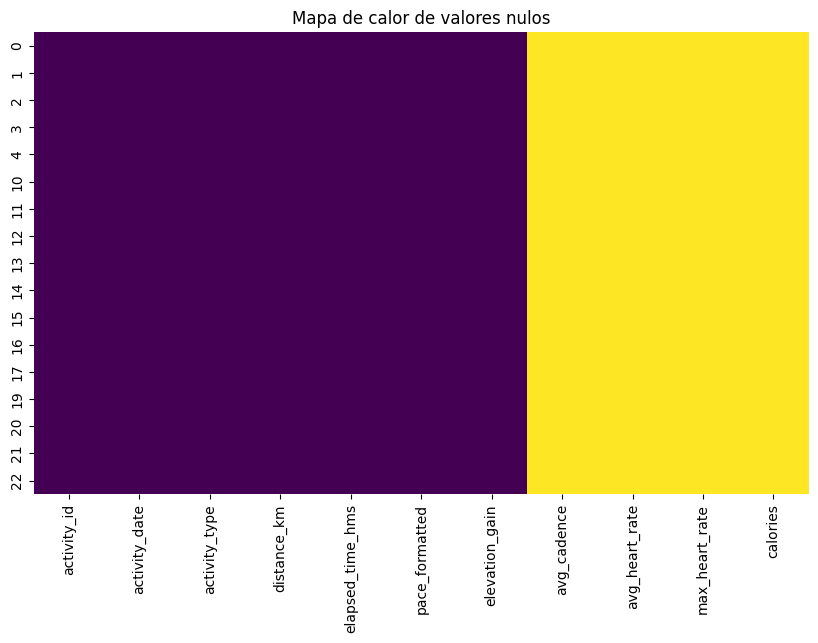

Estadísticos de variables seleccionadas:
       distance_km  pace_formatted  calories
count    17.000000       17.000000       0.0
mean      6.023529        6.003529       NaN
std       1.339743        0.344763       NaN
min       4.110000        5.390000       NaN
25%       5.270000        6.010000       NaN
50%       6.010000        6.100000       NaN
75%       6.180000        6.240000       NaN
max      10.200000        6.390000       NaN


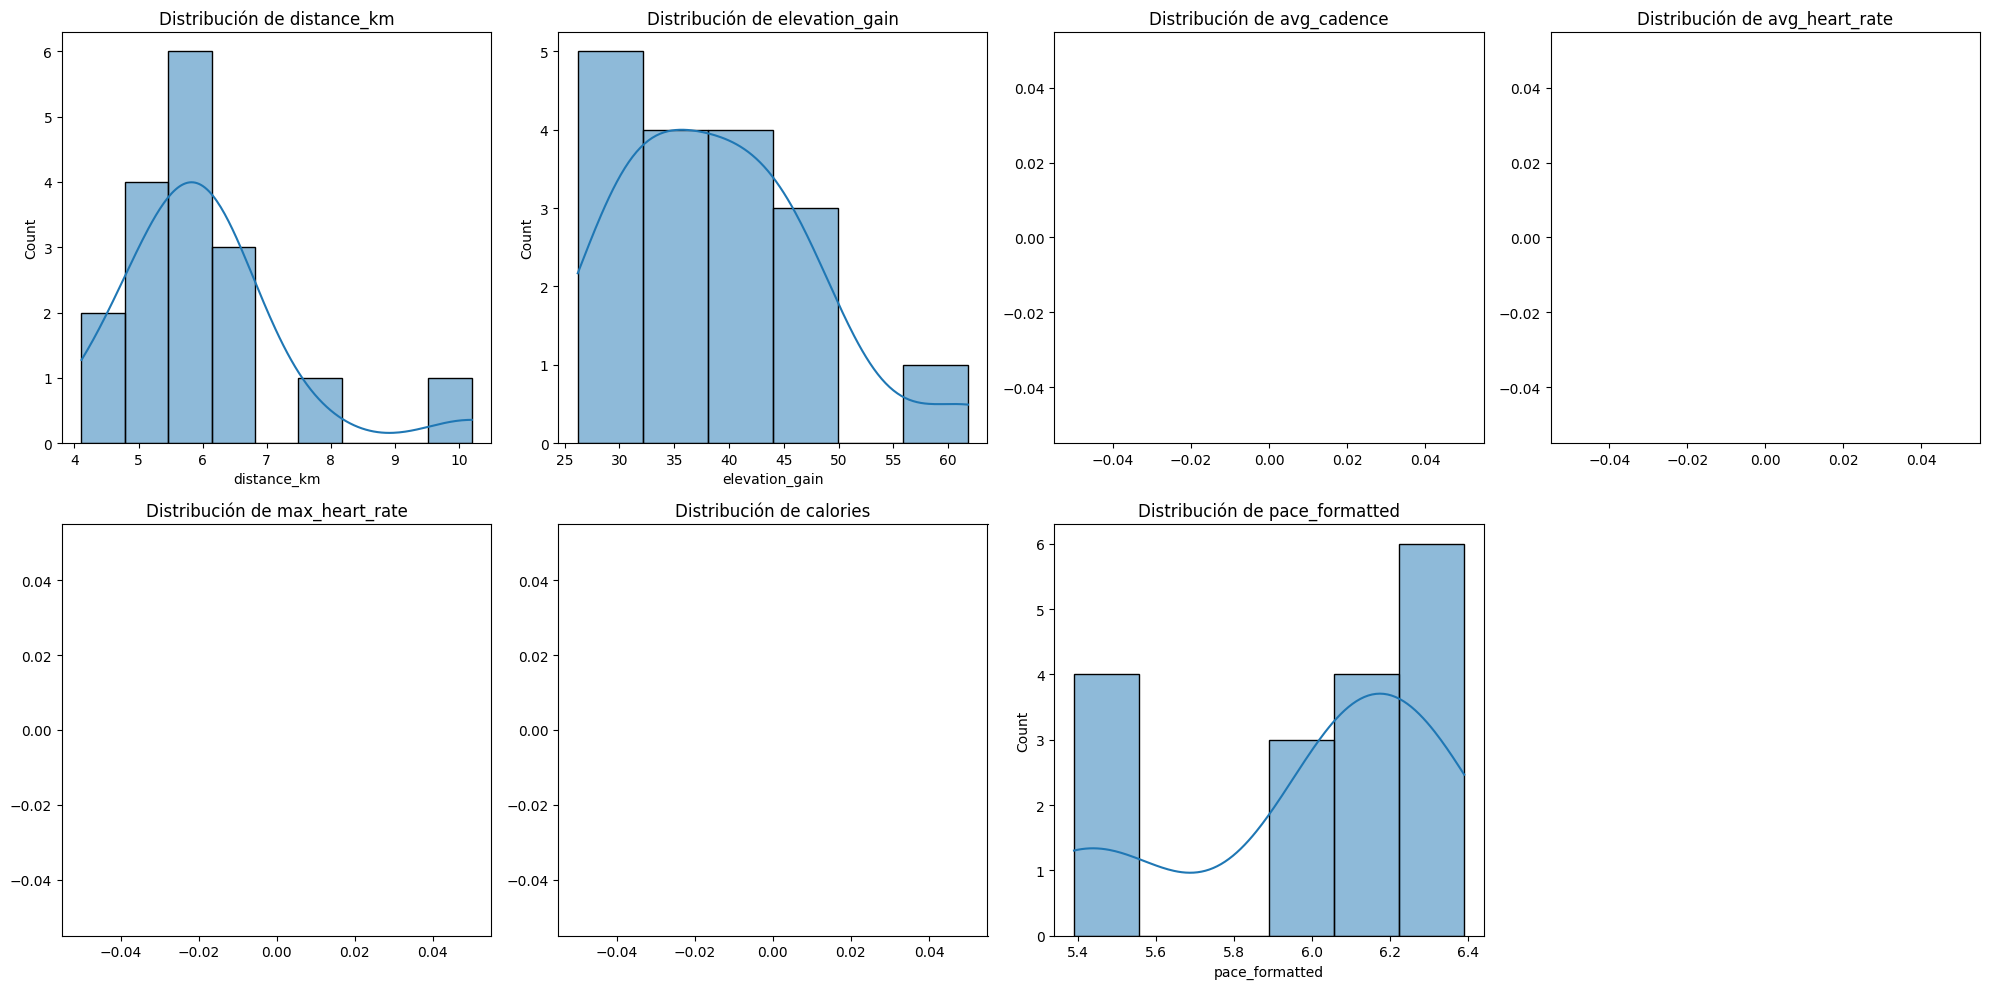

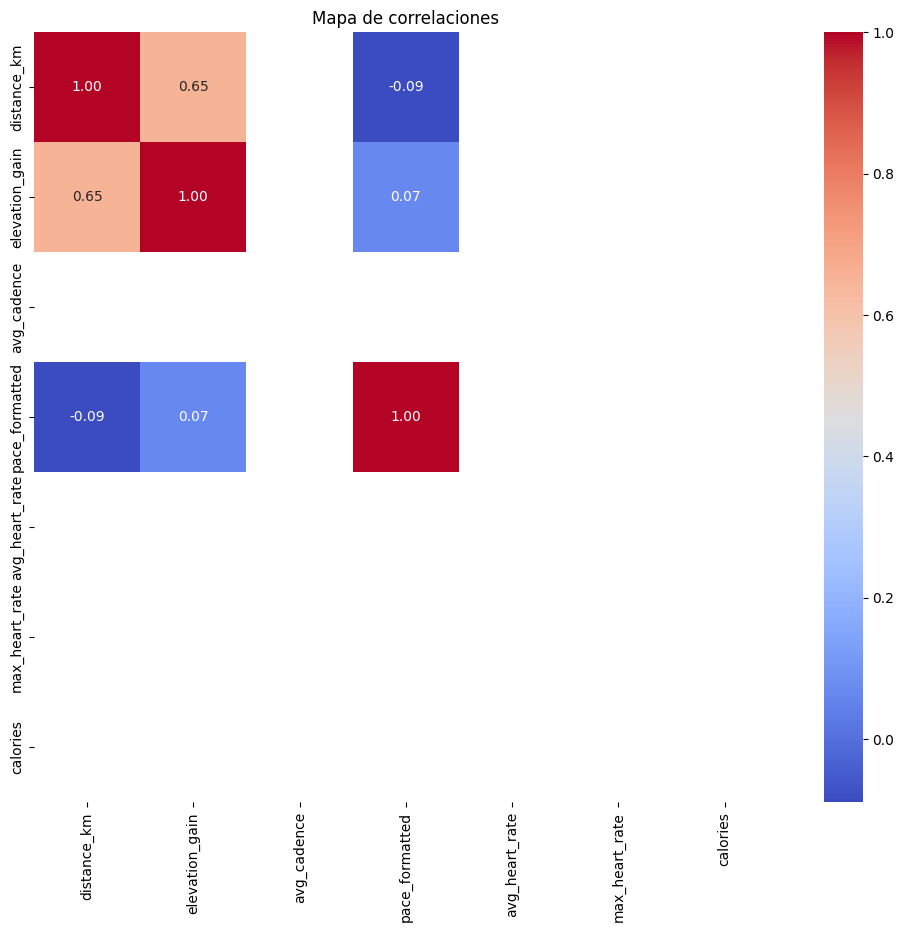

In [8]:
def EDA(data):
    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km', 'elapsed_time_hms',
        'pace_formatted', 'elevation_gain', 'avg_cadence',
        'avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    data = data[columnas]

    # Gráficos para ver nulos
    if data.isnull().sum().sum() == 0:
        print("No hay valores nulos en las variables seleccionadas.")
    else:
        plt.figure(figsize=(10,6))
        sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
        plt.title('Mapa de calor de valores nulos')
        plt.show()

    # Estadísticos de variables seleccionadas
    print("Estadísticos de variables seleccionadas:")
    print(data[['distance_km', 'pace_formatted', 'calories']].describe())

    # Distribución de variables continuas en una sola imagen
    dist_vars = ['distance_km', 'elevation_gain', 'avg_cadence', 'avg_heart_rate', 'max_heart_rate', 'calories', 'pace_formatted']
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()

    for i, var in enumerate(dist_vars):
        if i < len(axes):
            ax = axes[i]
            if data[var].dtype == 'object':
                data[var].value_counts().plot(kind='bar', ax=ax)
                ax.set_ylabel('Frecuencia')
            else:
                sns.histplot(data[var].dropna(), kde=True, ax=ax)
            ax.set_title(f'Distribución de {var}')

    # Eliminar el subplot vacío si hay menos variables que subplots
    for j in range(len(dist_vars), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Mapa de correlaciones (todas las variables numéricas relevantes)
    plt.figure(figsize=(12,10))
    corr_vars = ['distance_km', 'elevation_gain', 'avg_cadence','pace_formatted', 'avg_heart_rate', 'max_heart_rate', 'calories']
    corr = data[corr_vars].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Mapa de correlaciones')
    plt.show()

EDA(strava_limpio)
